In [1]:
from project_handlers.project_info import ProjectInfo
from project_handlers.project_data_handler import ProjectDataHandler
import utils.plotting
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from lib.models.rppg_transforms import RollingNormalize, RPPGDetrend, RPPGICA, HRPredict, MaxFreqChannelSelector, SignalToPowerAndFreq, AverageModule
import torch
from torchvision import transforms

In [2]:
dataset_name = 'small'

In [3]:
info = ProjectInfo()
t_size = info.t_size
data_root = info.data_root
sampling_rate = info.sampling_rate

In [4]:
data_handler = ProjectDataHandler(info.data_root)
dataset = data_handler.load_data(dataset_name)

data_loader = DataLoader(dataset, batch_size=5)
X, y = next(iter(data_loader))
x_example, y_example = X[0,:,:,0].view(1,3,t_size,1), y[0].view(1,200)
print('x example shape: ' + str(x_example.shape))
print('y example shape: ' + str(y_example.shape))

x example shape: torch.Size([1, 3, 200, 1])
y example shape: torch.Size([1, 200])


In [5]:
ica = RPPGICA()

rolling10 = RollingNormalize(10)
rolling30 = RollingNormalize(30)
rolling100 = RollingNormalize(100)

detrend = RPPGDetrend()

power_freq = SignalToPowerAndFreq(sampling_rate)
max_selector = MaxFreqChannelSelector()
average_module = AverageModule()

hr_predict = HRPredict(sampling_rate)

# Detrending

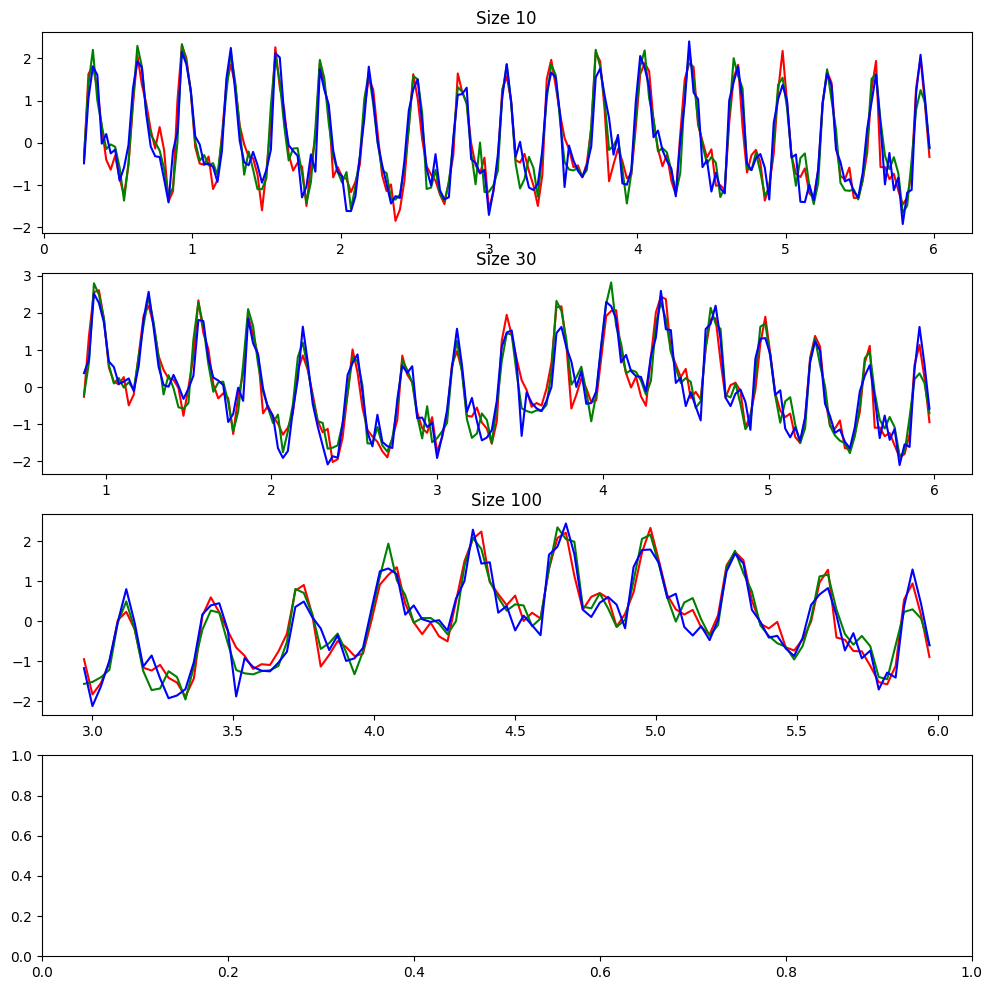

In [6]:
t = np.arange(0,t_size)*sampling_rate
nd = zip(
    ['Size 10', 'Size 30', 'Size 100'],
    [rolling10, rolling30, rolling100, detrend]
    )
for (name, d), ax in utils.plotting.iter_grid_plt(nd, (4, 1)):
    ax.title.set_text(name)
    x_detrended = d(x_example)
    t_trimmed = d.trim(t)
    utils.plotting.plot_signals(t_trimmed, torch.squeeze(x_detrended), ax=ax)

x_example = rolling100(x_example)
t = rolling100.trim(t)

# ICA

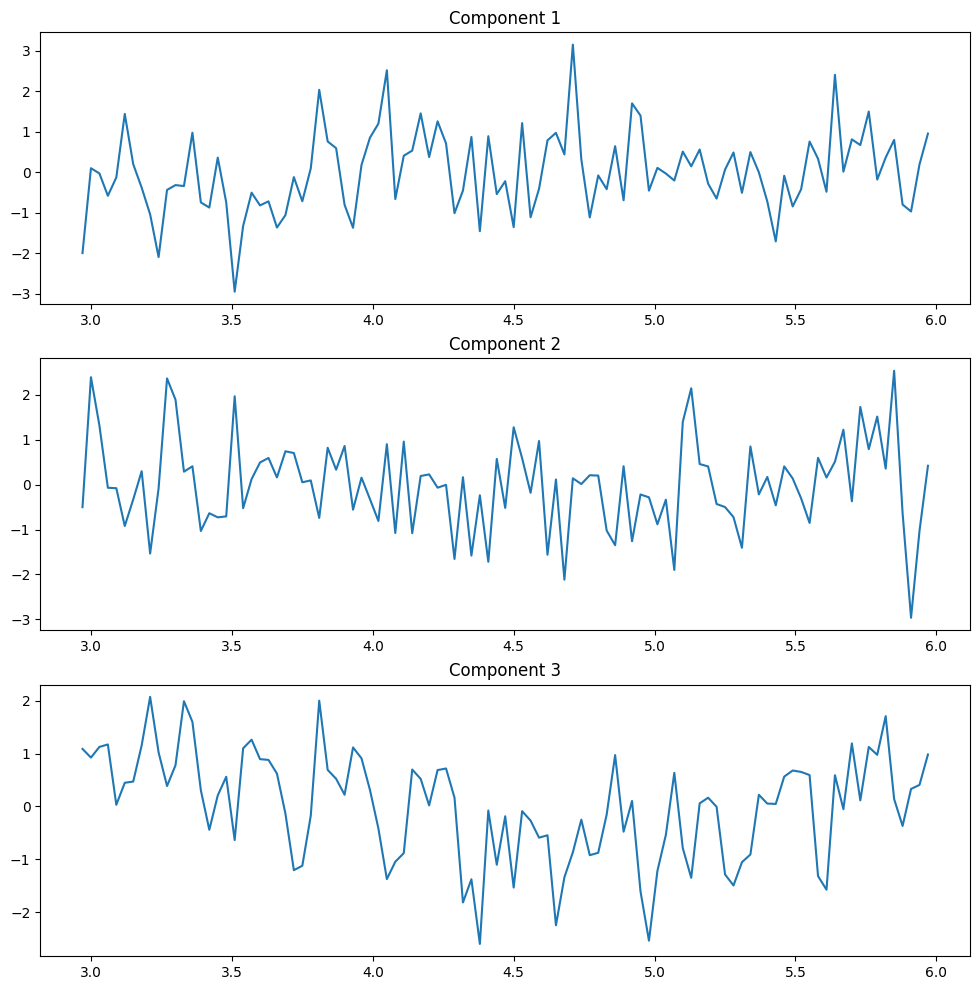

In [7]:
x_example = ica(x_example)
for idx, (xi, ax) in enumerate(utils.plotting.iter_grid_plt(torch.squeeze(x_example), (3, 1))):
    ax.title.set_text(f'Component {idx + 1}')
    ax.plot(t, xi)
plt.show()

# FFT

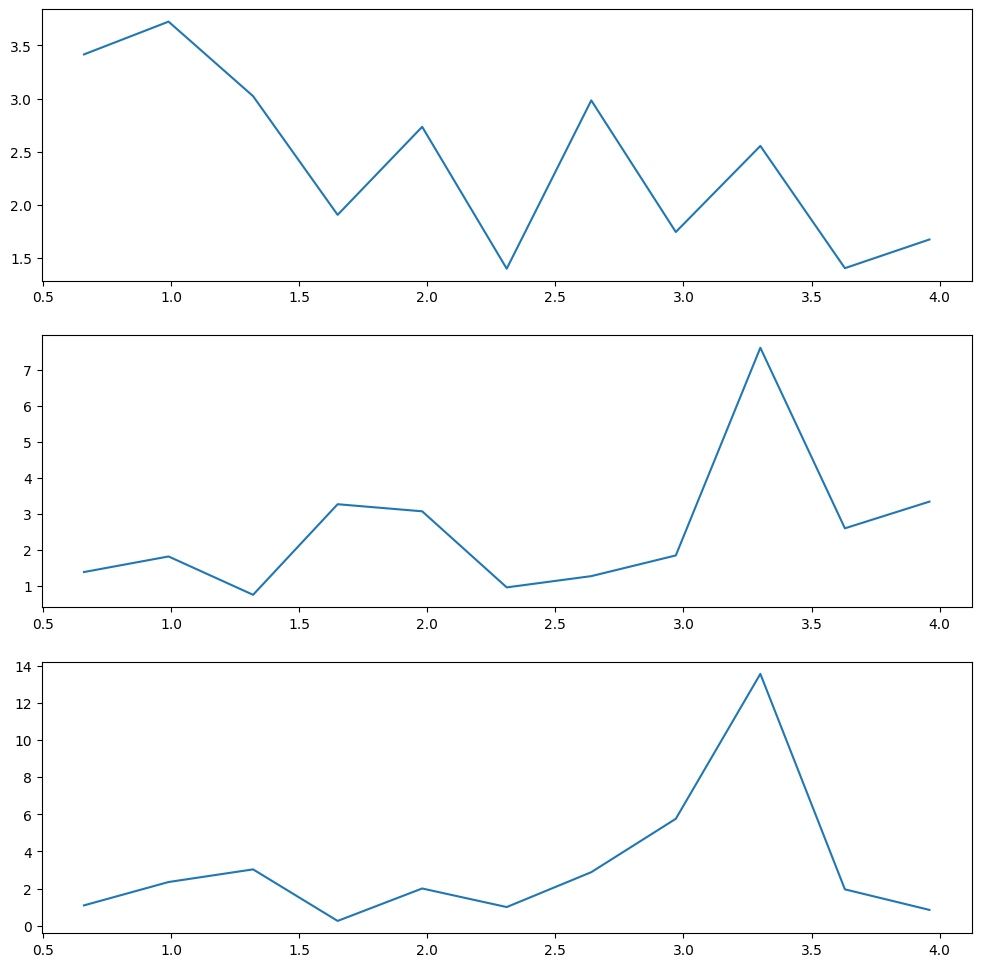

torch.Size([1, 3, 2, 1])
torch.Size([1, 1])
Beats per sec tensor([3.3003])
Beats per min tensor([198.0198])


In [8]:
for xi, ax in utils.plotting.iter_grid_plt(torch.squeeze(x_example).numpy(), (3, 1)):
    x_fft, f = power_freq.rppg_fft_and_fftreq(xi)
    ax.plot(f, x_fft)
plt.show()

x_example = power_freq(x_example)
print(x_example.shape)
x_example = max_selector(x_example)
print(x_example.shape)
hr = average_module(x_example)
print('Beats per sec ' + str(hr))
print('Beats per min ' + str(hr*60))

# Truth

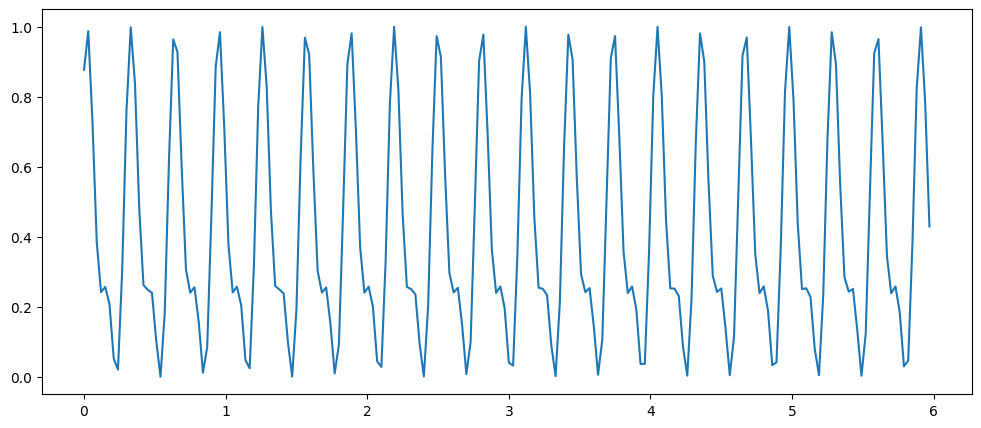

x example shape: torch.Size([1, 1])
y example shape: torch.Size([1, 200])


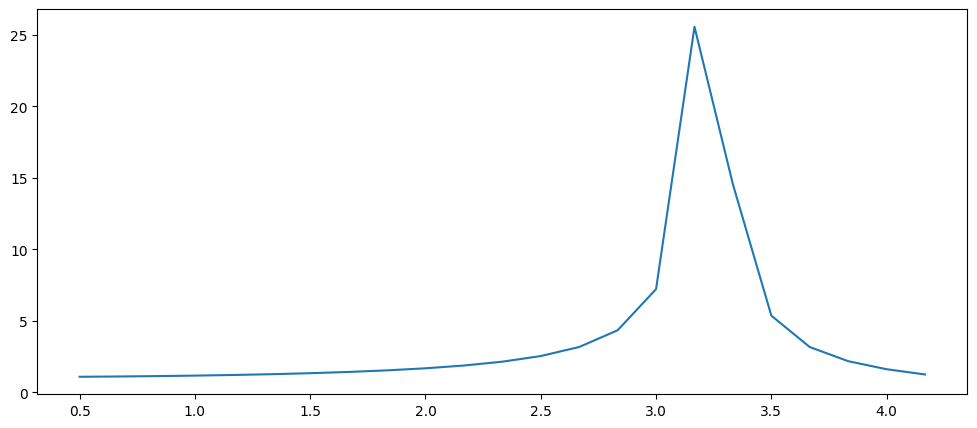

Beats per sec tensor([[3.1667]], dtype=torch.float64)
Beats per min tensor([[190.]], dtype=torch.float64)


In [9]:
t = np.arange(0,t_size)*sampling_rate

plt.figure(figsize=(12,5))
plt.plot(t, torch.squeeze(y_example))
plt.show()
print('x example shape: ' + str(x_example.shape))
print('y example shape: ' + str(y_example.shape))
#print(torch.unsqueeze(y_example,0).shape)
for yi in y_example.numpy():
    x_fft, f = hr_predict.rppg_fft_and_fftreq(yi)
    plt.figure(figsize=(12,5))
    plt.plot(f, x_fft)
    plt.show()

hr = hr_predict(y_example)
print('Beats per sec ' + str(hr))
print('Beats per min ' + str(hr*60))